<h1>GMM for Galaxy classification</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture

plt.rcParams['figure.figsize'] = (7,6)
plt.style.use('seaborn-whitegrid')

In [2]:
data = pd.read_csv('../Dataset/class_WHAN_BPT.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83826 entries, 0 to 83825
Data columns (total 8 columns):
id             83826 non-null object
xx_BPT         83826 non-null float64
yy_BPT         83826 non-null float64
class_BPT      83826 non-null int64
xx_WHAN        83826 non-null float64
yy_WHAN        83826 non-null float64
EW_NII_WHAN    83826 non-null float64
class_WHAN     83826 non-null int64
dtypes: float64(5), int64(2), object(1)
memory usage: 5.1+ MB


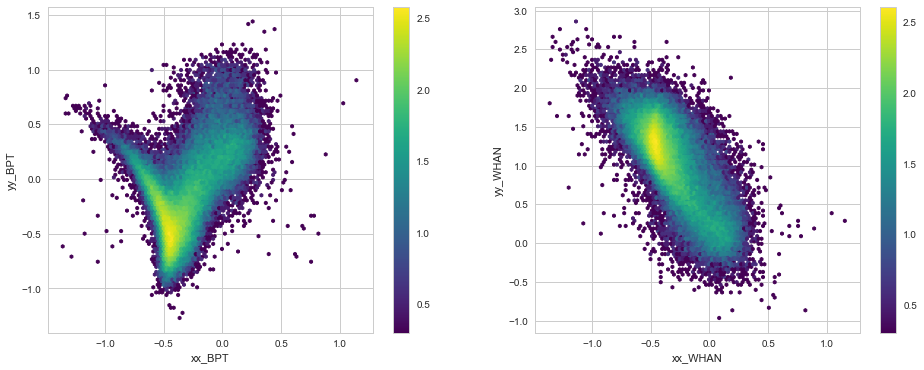

In [4]:
plt.figure(figsize=(16,6))

ax1 = plt.subplot(121)
data.plot.hexbin(x='xx_BPT',y='yy_BPT',mincnt=1,
                 bins='log',gridsize=101,cmap='viridis',ax=ax1)

ax2 = plt.subplot(122)
data.plot.hexbin(x='xx_WHAN',y='yy_WHAN',mincnt=1,
                 bins='log',gridsize=101,cmap='viridis',ax=ax2)

<h2>GMM clustering</h2>
<h3>2 Clusters</h2>

In [5]:
gmm2 = GaussianMixture(covariance_type='full',n_components=2)
gmm2.fit(data[['xx_BPT','yy_BPT','xx_WHAN','yy_WHAN']])
proba_gmm2 = gmm2.predict_proba(data[['xx_BPT','yy_BPT','xx_WHAN','yy_WHAN']])
labels2 = proba_gmm2.argmax(axis=1)

data['gmm2_proba1'] = proba_gmm2[:,0]
data['gmm2_proba2'] = proba_gmm2[:,1]

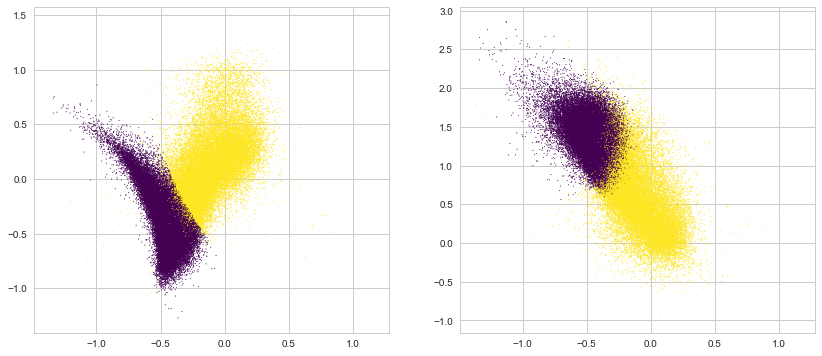

In [6]:
plt.figure(figsize=(14,6))

plt.subplot(121)
plt.scatter(data.xx_BPT,data.yy_BPT,c=labels2,s=0.4,cmap='viridis')

plt.subplot(122)
plt.scatter(data.xx_WHAN,data.yy_WHAN,c=labels2,s=0.4,cmap='viridis')

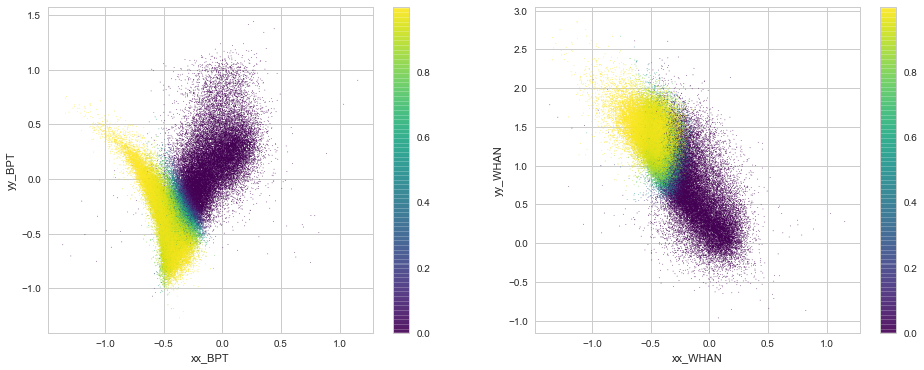

In [7]:
plt.figure(figsize=(16,6))

ax1 = plt.subplot(121)
data.plot.scatter(x='xx_BPT',y='yy_BPT',c=data.gmm2_proba1,
                  marker='.',s=1.0,cmap='viridis',alpha=0.7,ax=ax1)

ax2 = plt.subplot(122)
data.plot.scatter(x='xx_WHAN',y='yy_WHAN',c=data.gmm2_proba1,
                  marker='.',s=1.0,cmap='viridis',alpha=0.7,ax=ax2)

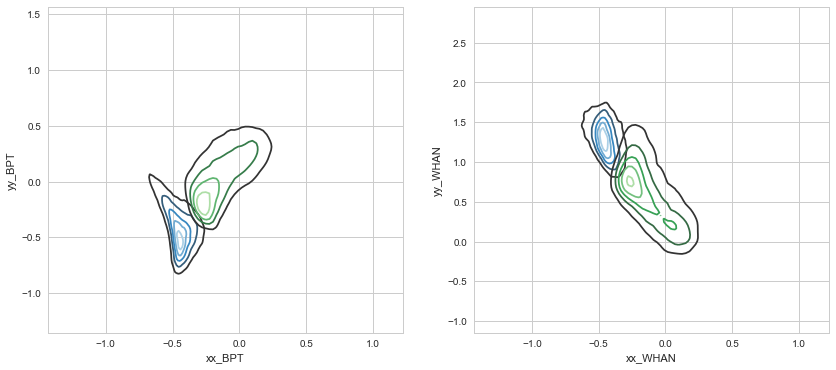

In [8]:
plt.figure(figsize=(14,6))

ax1 = plt.subplot(121)
sns.kdeplot(data[data.gmm2_proba1>0.5].xx_BPT,data[data.gmm2_proba1>0.5].yy_BPT,
            n_levels=5,ax=ax1,cmap='Blues_d')
sns.kdeplot(data[data.gmm2_proba2>0.5].xx_BPT,data[data.gmm2_proba2>0.5].yy_BPT,
            n_levels=5,ax=ax1,cmap='Greens_d')

ax2 = plt.subplot(122)
sns.kdeplot(data[data.gmm2_proba1>0.5].xx_WHAN,data[data.gmm2_proba1>0.5].yy_WHAN,
            n_levels=5,ax=ax2,cmap='Blues_d')
sns.kdeplot(data[data.gmm2_proba2>0.5].xx_WHAN,data[data.gmm2_proba2>0.5].yy_WHAN,
            n_levels=5,ax=ax2,cmap='Greens_d')

<h3>3 Clusters</h3>

In [9]:
gmm3 = GaussianMixture(covariance_type='full',n_components=3)
gmm3.fit(data[['xx_BPT','yy_BPT','xx_WHAN','yy_WHAN']])
proba_gmm3 = gmm3.predict_proba(data[['xx_BPT','yy_BPT','xx_WHAN','yy_WHAN']])
labels3 = proba_gmm3.argmax(axis=1)

data['gmm3_proba1'] = proba_gmm3[:,0]
data['gmm3_proba2'] = proba_gmm3[:,1]
data['gmm3_proba3'] = proba_gmm3[:,2]

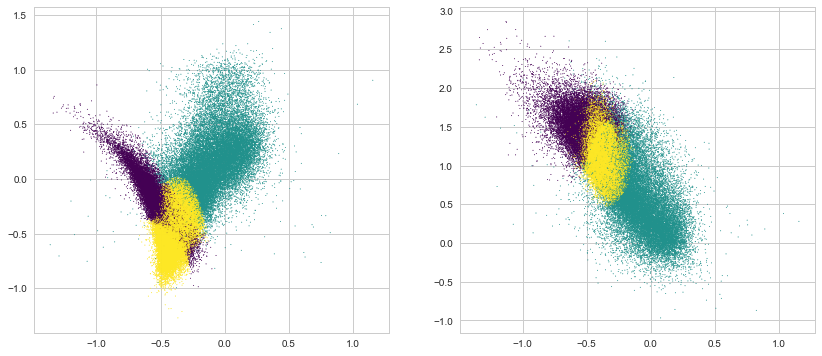

In [10]:
plt.figure(figsize=(14,6))

plt.subplot(121)
plt.scatter(data.xx_BPT,data.yy_BPT,c=labels3,s=0.4,cmap='viridis')

plt.subplot(122)
plt.scatter(data.xx_WHAN,data.yy_WHAN,c=labels3,s=0.4,cmap='viridis')

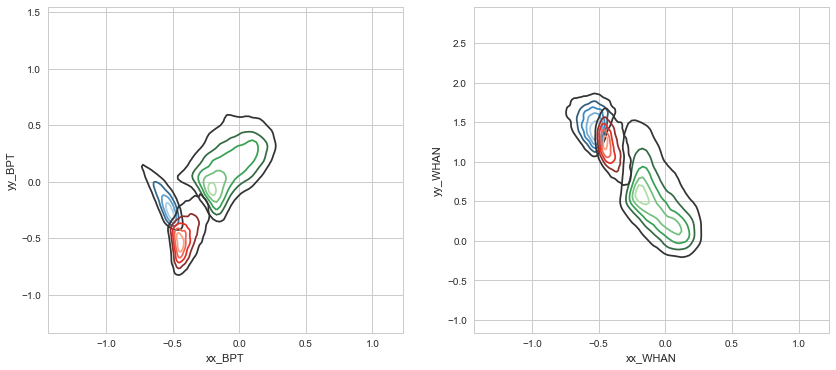

In [11]:
plt.figure(figsize=(14,6))

ax1 = plt.subplot(121)
sns.kdeplot(data[data.gmm3_proba1>0.5].xx_BPT,data[data.gmm3_proba1>0.5].yy_BPT,
            n_levels=5,ax=ax1,cmap='Blues_d')
sns.kdeplot(data[data.gmm3_proba2>0.5].xx_BPT,data[data.gmm3_proba2>0.5].yy_BPT,
            n_levels=5,ax=ax1,cmap='Greens_d')
sns.kdeplot(data[data.gmm3_proba3>0.5].xx_BPT,data[data.gmm3_proba3>0.5].yy_BPT,
            n_levels=5,ax=ax1,cmap='Reds_d')

ax2 = plt.subplot(122)
sns.kdeplot(data[data.gmm3_proba1>0.5].xx_WHAN,data[data.gmm3_proba1>0.5].yy_WHAN,
            n_levels=5,ax=ax2,cmap='Blues_d')
sns.kdeplot(data[data.gmm3_proba2>0.5].xx_WHAN,data[data.gmm3_proba2>0.5].yy_WHAN,
            n_levels=5,ax=ax2,cmap='Greens_d')
sns.kdeplot(data[data.gmm3_proba3>0.5].xx_WHAN,data[data.gmm3_proba3>0.5].yy_WHAN,
            n_levels=5,ax=ax2,cmap='Reds_d')

<h3>4 Clusters</h3>

In [12]:
gmm4 = GaussianMixture(covariance_type='full',n_components=4)
gmm4.fit(data[['xx_BPT','yy_BPT','xx_WHAN','yy_WHAN']])
proba_gmm4 = gmm4.predict_proba(data[['xx_BPT','yy_BPT','xx_WHAN','yy_WHAN']])
labels4 = proba_gmm4.argmax(axis=1)

data['gmm4_proba1'] = proba_gmm4[:,0]
data['gmm4_proba2'] = proba_gmm4[:,1]
data['gmm4_proba3'] = proba_gmm4[:,2]
data['gmm4_proba4'] = proba_gmm4[:,3]

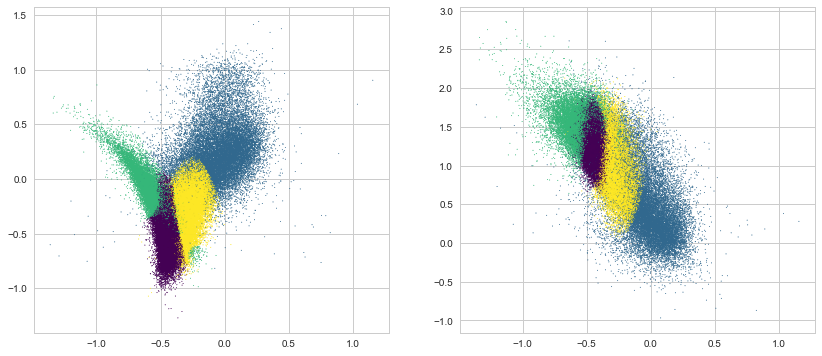

In [13]:
plt.figure(figsize=(14,6))

plt.subplot(121)
plt.scatter(data.xx_BPT,data.yy_BPT,c=labels4,s=0.4,cmap='viridis')

plt.subplot(122)
plt.scatter(data.xx_WHAN,data.yy_WHAN,c=labels4,s=0.4,cmap='viridis')

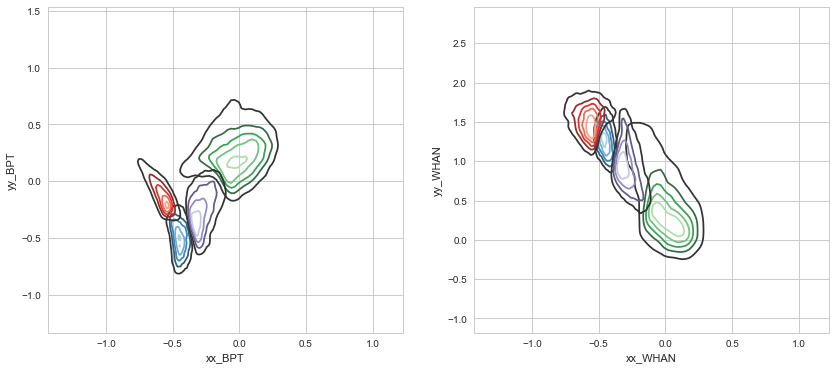

In [14]:
plt.figure(figsize=(14,6))

ax1 = plt.subplot(121)
sns.kdeplot(data[data.gmm4_proba1>0.5].xx_BPT,data[data.gmm4_proba1>0.5].yy_BPT,
            n_levels=5,ax=ax1,cmap='Blues_d')
sns.kdeplot(data[data.gmm4_proba2>0.5].xx_BPT,data[data.gmm4_proba2>0.5].yy_BPT,
            n_levels=5,ax=ax1,cmap='Greens_d')
sns.kdeplot(data[data.gmm4_proba3>0.5].xx_BPT,data[data.gmm4_proba3>0.5].yy_BPT,
            n_levels=5,ax=ax1,cmap='Reds_d')
sns.kdeplot(data[data.gmm4_proba4>0.5].xx_BPT,data[data.gmm4_proba4>0.5].yy_BPT,
            n_levels=5,ax=ax1,cmap='Purples_d')

ax2 = plt.subplot(122)
sns.kdeplot(data[data.gmm4_proba1>0.5].xx_WHAN,data[data.gmm4_proba1>0.5].yy_WHAN,
            n_levels=5,ax=ax2,cmap='Blues_d')
sns.kdeplot(data[data.gmm4_proba2>0.5].xx_WHAN,data[data.gmm4_proba2>0.5].yy_WHAN,
            n_levels=5,ax=ax2,cmap='Greens_d')
sns.kdeplot(data[data.gmm4_proba3>0.5].xx_WHAN,data[data.gmm4_proba3>0.5].yy_WHAN,
            n_levels=5,ax=ax2,cmap='Reds_d')
sns.kdeplot(data[data.gmm4_proba4>0.5].xx_WHAN,data[data.gmm4_proba4>0.5].yy_WHAN,
            n_levels=5,ax=ax2,cmap='Purples_d')